## SESSION 2 STARTER CODE
## Optimization and Error Analysis: Improving Deep Neural Networks


Multiclass Classification (Fashion MNIST)

Goal: Improve the model using regularization, callbacks, and error analysis.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Data Preparation (Using `tf.data`)

Fashion MNIST has **10 classes**:  
*T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot*


#### Why `tf.data`?
Previously, we passed NumPy arrays directly to `model.fit` and used `validation_split`.  
This works for small datasets but **doesn’t scale well**.  

Using `tf.data`:
- Combines **images + labels** into one dataset `(image, label)`.
- **Faster training** with parallel processing and prefetching.
- Handles **large datasets** that don’t fit in memory.
- Makes pipelines **cleaner and production-ready**.


#### Pipeline Steps
1. **from_tensor_slices()** – Create a dataset from NumPy arrays.  
2. **shuffle()** – Randomize sample order to prevent overfitting.  
3. **map()** – Apply preprocessing (normalize, reshape) in parallel.  
4. **batch()** – Group data into batches for training.  
5. **prefetch()** – Load next batch while the model trains on the current one.


> **Note:**  
> With `tf.data`, you no longer need to pass `train_labels` or use `validation_split`.  
> Just feed `train_ds` and `test_ds` directly to `model.fit`.

In [ ]:
# For tf.data optimization
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:

# Fashion MNIST: 10 classes of clothing items
class_names = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Load and Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# Preprocessing function
def preprocess_image(image, label):
    """
    This function will:
    1. Convert image to float32
    2. Normalize pixel values to [0,1]
    3. Expand dimensions so shape is (28, 28, 1)
    """
    image = tf.cast(image, tf.float32) / 255.0   # Hint: tf.cast(image, tf.float32) / 255.0
    return image, label

# Build tf.data pipeline for training

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    # Hint: Use from_tensor_slices to create a dataset from the NumPy arrays

train_ds = train_ds.shuffle(buffer_size=10000)
    # Hint: Shuffle with a buffer size of 10,000 to randomize order

train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    # Hint: Use map to apply the preprocess function in parallel

train_ds = train_ds.batch(32)
    # Hint: Batch the data with a batch size of 32

train_ds = train_ds.prefetch(AUTOTUNE)
  # Hint: Prefetch to load next batch while the current one is training


# Build tf.data pipeline for testing
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    # Hint: Same as above but no shuffle step needed for the test data

test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    # Hint: Map preprocessing function to test set

test_ds = test_ds.batch(32)
    # Hint: Batch with size 32

test_ds = test_ds.prefetch(AUTOTUNE)
    # Hint: Prefetch test batches as well

print("Train dataset structure:", train_ds)
print("Test dataset structure:", test_ds)

Train dataset structure: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
Test dataset structure: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


### Step 2: Build a Regularized Model

We now add:
- **Dropout**: Randomly "turns off" neurons to prevent overfitting.
- **L2 Regularization**: Penalizes large weights to encourage simpler models.

**Layer sequence:**
- Flatten → Dense + L2 → Dropout → Dense + L2 → Dropout → Dense + Softmax

**Key concepts:**
- Dropout rates typically range from 0.2 to 0.5
- L2 regularization strength (lambda) usually starts around 0.001

In [ ]:
# Build Regularized Functional Model

def build_regularized_functional():
    """
    Functional API model with Dropout and L2 regularization
    """
    l2_reg = tf.keras.regularizers.l2(0.001)

    inputs = tf.keras.Input(shape=(28, 28), name="Input_Layer")  # Hint: Input(shape=(28, 28), name="Input_Layer")
    x = tf.keras.layers.Flatten(name="Flatten")(inputs)       # Hint: Flatten(name="Flatten")(inputs)

    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2_reg)(x)       # Hint: Dense(512, activation='relu', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Dropout(0.3)(x)       # Hint: Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2_reg)(x)       # Hint: Dense(256, activation='relu', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Dropout(0.3)(x)       # Hint: Dropout(0.3)(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2_reg)(x)       # Hint: Dense(128, activation='relu', kernel_regularizer=l2_reg)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x) # Hint: Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Functional_Model_Regularized")   # Hint: Model(inputs=inputs, outputs=outputs, name="Functional_Model_Regularized")
    return model

### Step 3: Compile the Model

For multiclass classification:
- **Loss**: Sparse categorical cross-entropy (labels are integers 0-9)
- **Output activation**: Softmax
- **Metrics**: Accuracy

**Tip:**
If accuracy doesn't improve:
- Try lowering the learning rate
- Check if normalization is applied correctly

In [ ]:
# Compile Model

model = build_regularized_functional()  # Hint: build_regularized_sequential() or build_regularized_functional()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Hint: tf.keras.optimizers.Adam(learning_rate=0.001)
    loss='sparse_categorical_crossentropy',       # Hint: 'sparse_categorical_crossentropy'
    metrics=['accuracy']
)

Model: "Functional_Model_Regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4: Using Callbacks

Callbacks help us automate training monitoring:
- **EarlyStopping**: Stops training when validation loss stops improving.
- **ModelCheckpoint**: Saves the best model during training.
- **ReduceLROnPlateau**: Lowers the learning rate when progress stalls.

**Why important:**
- Prevents wasted training time.
- Avoids overfitting by stopping early.
- Saves the best version of your model automatically.


### Training with `tf.data` Pipelines

In Session 1, we trained the model by passing NumPy arrays like this:

model.fit(train_images, train_labels, validation_split=0.2)


### Now, since we built our datasets using `tf.data`:
- Each element in `train_ds` already contains both **images and labels** as `(image, label)`.
- We pass `test_ds` directly to `validation_data` for evaluation.
- **No need for `validation_split` or separate `train_labels`.**

This method is **faster, scalable, and production-ready**.

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]

# Train Model
history = model.fit(
    train_ds,         # Hint: train_ds
    validation_data=test_ds,  # Hint: test_ds
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7377 - loss: 1.3017
Epoch 1: val_loss improved from inf to 0.70118, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7378 - loss: 1.3012 - val_accuracy: 0.8270 - val_loss: 0.7012 - learning_rate: 0.0010
Epoch 2/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8206 - loss: 0.6881
Epoch 2: val_loss improved from 0.70118 to 0.60429, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8206 - loss: 0.6881 - val_accuracy: 0.8426 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 3/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8270 - loss: 0.6267
Epoch 3: val_loss improved from 0.60429 to 0.57135, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8270 - loss: 0.6267 - val_accuracy: 0.8438 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 4/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10

In [18]:
# Evaluate Model
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8888
Test Loss: 0.3951


### Step 5: Error Analysis

After training, we:
- Generate predictions on the test set.
- Create a **confusion matrix** to see which classes the model struggles with.

**Why this matters:**
- Accuracy alone can hide problems.
- Confusion matrix shows:
  - Which classes are confused with each other.
  - Where more data or augmentation may be needed.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


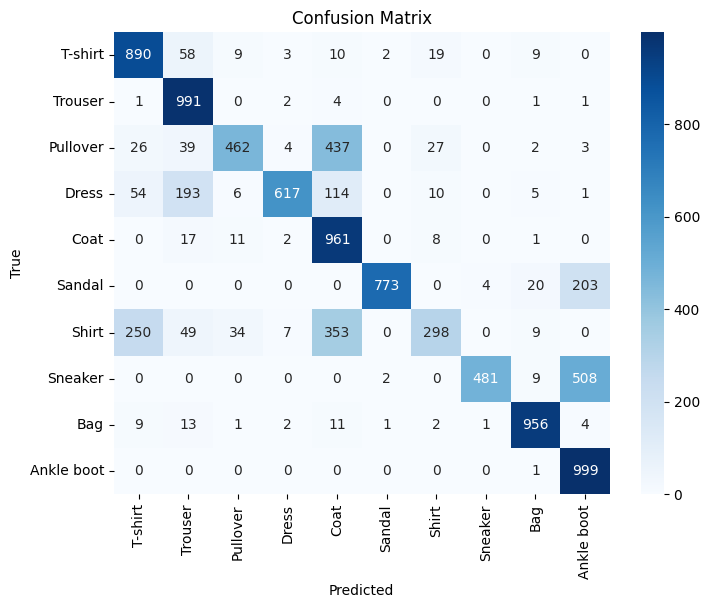

In [19]:

# Confusion Matrix
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Step 6: Analyzing Learning Curves

We plot:
- Training vs Validation Loss
- Training vs Validation Accuracy

**Interpretation:**
- If validation loss is much higher than training loss → Overfitting
- If both are low and flat → Underfitting
- Goal is to see both curves converge smoothly.

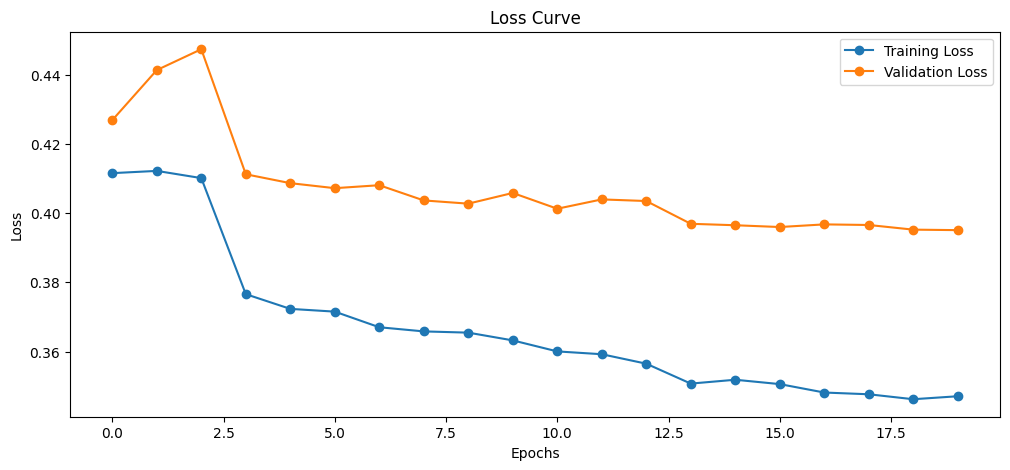

In [20]:
# Visualize Learning Curves

plt.figure(figsize=(12,5))
# Loss curve
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


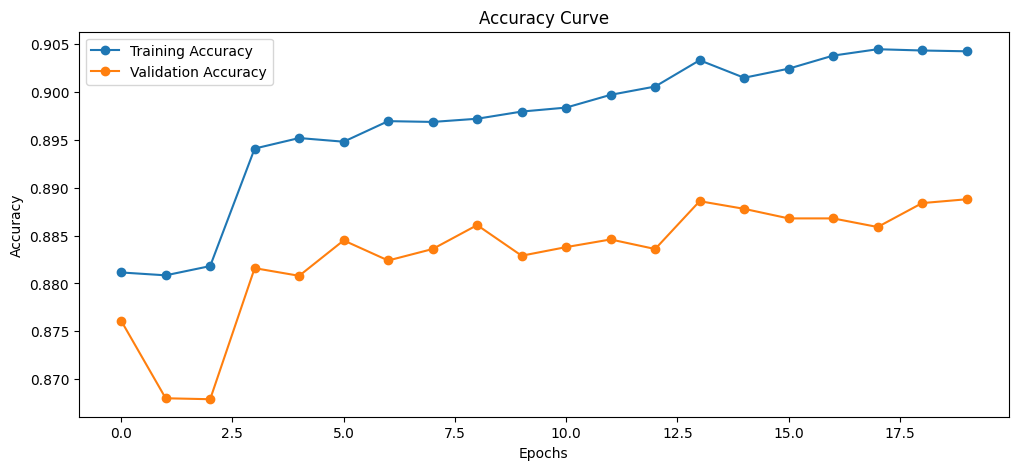

In [21]:
# Loss curve
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Challenge: Hyperparameter Tuning

In this session, we built a deep learning model and learned how to:
- Add Dropout and L2 Regularization
- Use callbacks such as EarlyStopping and ModelCheckpoint
- Perform error analysis using a confusion matrix

Now it is time to extend these skills by experimenting with hyperparameter tuning.

### Goal
The goal is to find the best combination of hyperparameters that improve your model's performance on the Fashion MNIST dataset.

### Hyperparameters You Can Tune
Below are some hyperparameters to experiment with:

1. **Learning Rate**  
   - Try values like `0.001`, `0.0005`, or `0.0001`.

2. **Batch Size**  
   - Experiment with `32`, `64`, `128`.

3. **Number of Hidden Layers**  
   - Add or remove dense layers to see how model depth affects performance.

4. **Neurons per Layer**  
   - Try different layer sizes such as `64`, `128`, `256`, `512`.

5. **Dropout Rate**  
   - Experiment with `0.2`, `0.3`, and `0.5` to find the best balance between regularization and learning.

6. **L2 Regularization Strength**  
   - Test different values like `0.0001`, `0.001`, and `0.01`.


### Instructions
1. **Start Small**  
   Change one hyperparameter at a time so you can clearly observe its effect on performance.

2. **Track Results**  
   Record each experiment, noting:
   - Hyperparameter values
   - Validation accuracy
   - Validation loss

3. **Compare and Analyze**
   Identify which combination of hyperparameters gave the best generalization on the validation set.


### Optional: Automate Tuning
For additional practice, you can try automating the search for optimal hyperparameters using tools such as KerasTuner or Optuna.



In [22]:
!pip install keras-tuner

import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of neurons in the first layer
    model.add(tf.keras.layers.Dense(
        units=hp.Choice('units', [64, 128, 256, 512]),
        activation='relu'
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model